### PUC Minas - Trabalho de Conclusão de Curso
# **Análise de algoritmos de aprendizado profundo não supervisionado para a segmentação de fácies sísmicas**
### **Aluno:** Bryan S. Oliveira
### **Orientador:** Alexei M. C. Machado

## Baixando os dados e colocando na pasta "datasets"
F3 Block: https://zenodo.org/record/3755060/files/data.zip

Penobscot: https://zenodo.org/record/3924682/files/dataset.h5

In [1]:
!mkdir datasets

# Penobscot
!wget https://zenodo.org/record/3924682/files/dataset.h5
!mkdir datasets/penobscot
!mv dataset.h5 datasets/penobscot/
!mkdir datasets/penobscot/splits

# F3 Block
!wget https://zenodo.org/record/3755060/files/data.zip
!mkdir datasets/f3
!openssl dgst -md5 data.zip
!unzip data.zip
!mkdir data/splits
!mv data/train datasets/f3/
!mv data/test_once datasets/f3/
!mkdir datasets/f3/splits

--2023-12-17 03:09:38--  https://zenodo.org/record/3924682/files/dataset.h5
Resolving zenodo.org (zenodo.org)... 188.184.103.159, 188.185.79.172, 188.184.98.238, ...
Connecting to zenodo.org (zenodo.org)|188.184.103.159|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/3924682/files/dataset.h5 [following]
--2023-12-17 03:09:39--  https://zenodo.org/records/3924682/files/dataset.h5
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 2268562702 (2.1G) [application/octet-stream]
Saving to: ‘dataset.h5’

dataset.h5          100%[===================>]   2.11G   121MB/s    in 27s     

2023-12-17 03:10:06 (79.4 MB/s) - ‘dataset.h5’ saved [2268562702/2268562702]

--2023-12-17 03:10:07--  https://zenodo.org/record/3755060/files/data.zip
Resolving zenodo.org (zenodo.org)... 188.185.79.172, 188.184.98.238, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.185.79.172|:443... connected.

# Bibliotecas Necessárias

In [2]:
import os
import torch
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
from functools import partial
from operator import itemgetter
import matplotlib.pyplot as plt
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.utils import save_image
import torchvision.transforms as transforms
import torchvision.transforms.functional as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from scipy.ndimage import distance_transform_edt as distance
import itertools
import h5py
import cv2

# Autoencoder Convolucional

In [3]:
"""
Deep Convolutional Autoencoder
Bryan S. Oliveira
TCC - PUC/2023
"""


class ConvAutoencoder(nn.Module):
  def __init__(self):
      super(ConvAutoencoder, self).__init__()

      self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
      self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
      self.pool = nn.MaxPool2d(2, 2)

      self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
      self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)


  def encoder(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    return x


  def decoder(self, x):
    x = F.relu(self.t_conv1(x))
    x = F.sigmoid(self.t_conv2(x))
    return x


  def forward(self, x):
      x = self.encoder(x)
      self.compressed = x
      x = self.decoder(x)
      return x


  def get_compressed_representation(self):
      return self.compressed

# Data Loader

Código para carregar os datasets e gerar os splits que serão usados no treino e no teste

In [4]:
"""
Data Loader de Treinamento
Bryan S. Oliveira
TCC - PUC/2023
"""


# Função pra criar os patches de treino (inlines e crosslines)
def split_train(stride, patch_size, dataset='f3'):

    if (dataset == 'f3'):
      seismic = np.load('datasets/f3/train/train_seismic.npy')
      i_range, x_range, depth = seismic.shape
    elif (dataset == 'penobscot'):
      seismic = h5py.File('datasets/penobscot/dataset.h5', 'r')
      seismic = np.squeeze(seismic['features'])
      i_range, depth, x_range = seismic.shape
      print(seismic.shape)

    print('🔹 Gerando os splits de treino')

    patch_list = []
    horizontal = patch_size[0]
    vertical   = patch_size[1]

    # Gerando os patches INLINE
    for i in range(i_range):
        for j in range(0, x_range-horizontal-1, stride):
            for k in range(0, depth-vertical-1, stride):
                patch_name = f'inline_{i}_{j}_{k}' if dataset == 'f3' else f'inline_{i}_{k}_{j}'
                patch_list.append(patch_name)

    # Gerando os patches XLINE
    for i in range(0, i_range-horizontal-1, stride):
        for j in range(x_range):
            for k in range(0, depth-vertical-1, stride):
                patch_name = f'xline_{i}_{j}_{k}' if dataset == 'f3' else f'xline_{i}_{k}_{j}'
                patch_list.append(patch_name)


    # Divide a lista em treinamento e validação
    train_list, val_list = train_test_split(patch_list, train_size=0.99, shuffle=True)

    print('\n🔹 Quantidade de patches: ' + str(len(train_list)))

    # Salva os slices num arquivo
    file_object = open('datasets/' + dataset + '/splits/train_patches.txt', 'w')

    file_object.write('\n'.join(train_list))
    file_object.close()




# Classe que implementa o Dataset de sísmicas
class SeismicDataset(Dataset):

    def __init__(self, patch_size, is_transform=True, dataset='f3', split='train'):
        self.split = split
        self.patch_size = patch_size
        self.is_transform = is_transform
        self.dataset = dataset

        # Carregando o cubo 3D correspondente ao treino/teste
        if (dataset == 'f3'):
          if (split == 'train'):
            self.seismic = np.load('datasets/f3/train/train_seismic.npy')
          else:
            self.seismic = np.load('datasets/f3/test_once/' + split + '_seismic.npy')

        elif (dataset == 'penobscot'):
          self.seismic = h5py.File('datasets/penobscot/dataset.h5')
          self.seismic = np.squeeze(self.seismic['features'])

        splits = 'datasets/' + dataset + '/splits/' + split + '_patches.txt'

        # Pegando os splits dos patches já separados
        file_list = tuple(open(splits, 'r'))
        file_list = [id_.rstrip() for id_ in file_list]
        self.patches = file_list


    def __len__(self):
        return len(self.patches)


    def __getitem__(self, index):
        patch_name = self.patches[index]

        # Pega a direção (inline/xline) e a posição do slice (x,y,z)
        if (self.dataset == 'f3'):
          direction, inline, cross, depth = patch_name.split(sep='_')
        else:
          direction, inline, depth, cross = patch_name.split(sep='_')

        inline, cross, depth = int(inline), int(cross), int(depth)

        horizontal = self.patch_size[0]
        vertical   = self.patch_size[1]

        # Pega o recorte de tamanho (patch_size) do slice
        if direction == 'inline':
            if (self.dataset == 'f3'):
              image = self.seismic[inline, cross:cross+horizontal, depth:depth+vertical]
            else:
              image = self.seismic[inline, depth:depth+vertical, cross:cross+horizontal]

        elif direction == 'xline':
            if (self.dataset == 'f3'):
              image = self.seismic[inline:inline+horizontal, cross, depth:depth+vertical]
            else:
              image = self.seismic[inline:inline+horizontal, depth:depth+vertical, cross]

        if self.is_transform:
            image = self.transform(image)

        return image


    def transform(self, image):
        # to be in the BxCxHxW that PyTorch uses:
        image = image.T
        image = np.expand_dims(image,0)
        image = torch.from_numpy(image).float()

        return image

# Treinamento

In [5]:
"""
Processo de treinamento do Autoencoder
Bryan S. Oliveira
TCC - PUC/2023
"""

def train(patch_size, stride, dataset):

  # Processador ou GPU
  device = torch.device(
      "cuda" if torch.cuda.is_available()
      else "cpu"
  )

  print('🔹 Device configurado -> ' + str(device))

  # Constantes de treinamento
  NUM_EPOCHS = 20
  LEARNING_RATE = 0.003
  BATCH_SIZE = 256

  # Gera os splits de treino
  split_train(stride, patch_size, dataset)

  print('\n✅ Gerou splits de treino')

  # Cria o dataset de treino
  train_dataset = SeismicDataset(is_transform=True, patch_size=patch_size, dataset=dataset, split='train')
  train_loader = DataLoader(
      train_dataset,
      batch_size=BATCH_SIZE,
      shuffle=True
  )

  print('\n✅ Gerou o dataset completo de treino \n')


  # Criando o modelo
  model = ConvAutoencoder().to(device)
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

  print('🔹 Modelo (Autoencoder) e Loss (Mean Squared Error) instanciados')
  print(f'🔹 {NUM_EPOCHS} épocas, lr = {LEARNING_RATE}, batch = {BATCH_SIZE}')
  print('🔹 Começando o treinamento...\n')


  # Processo de treinamento
  train_loss = []
  for epoch in range(NUM_EPOCHS):
      model.train()
      running_loss = 0.0

      img_test = None
      predict_test = None

      for data in train_loader:
          images = data.to(device)
          optimizer.zero_grad()

          # Roda o modelo
          outputs = model(images)

          loss = criterion(outputs, images)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()

      loss = running_loss / len(train_loader)
      train_loss.append(loss)

      print('Epoch {} of {}, Train Loss: {:.4f}'.format(epoch+1, NUM_EPOCHS, loss))

  print('\n✅ Treinamento Finalizado!\n')
  plt.plot(train_loss)

  return model

🔹 Device configurado -> cuda
🔹 Gerando os splits de treino

🔹 Quantidade de patches: 1334173

✅ Gerou splits de treino

✅ Gerou o dataset completo de treino 

🔹 Modelo (Autoencoder) e Loss (Mean Squared Error) instanciados
🔹 20 épocas, lr = 0.003, batch = 256
🔹 Começando o treinamento...

Epoch 1 of 20, Train Loss: 0.0286
Epoch 2 of 20, Train Loss: 0.0265
Epoch 3 of 20, Train Loss: 0.0265
Epoch 4 of 20, Train Loss: 0.0264
Epoch 5 of 20, Train Loss: 0.0263
Epoch 6 of 20, Train Loss: 0.0262
Epoch 7 of 20, Train Loss: 0.0259
Epoch 8 of 20, Train Loss: 0.0258
Epoch 9 of 20, Train Loss: 0.0257
Epoch 10 of 20, Train Loss: 0.0256
Epoch 11 of 20, Train Loss: 0.0256
Epoch 12 of 20, Train Loss: 0.0256
Epoch 13 of 20, Train Loss: 0.0256
Epoch 14 of 20, Train Loss: 0.0255
Epoch 15 of 20, Train Loss: 0.0255
Epoch 16 of 20, Train Loss: 0.0255
Epoch 17 of 20, Train Loss: 0.0255
Epoch 18 of 20, Train Loss: 0.0255
Epoch 19 of 20, Train Loss: 0.0255
Epoch 20 of 20, Train Loss: 0.0255

✅ Treinamento Fina

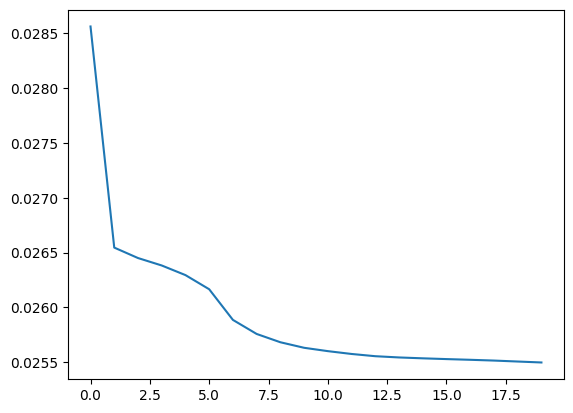

In [6]:
model = train(patch_size=(24,12), stride=10, dataset='f3')

# Loader de Testes

In [7]:
"""
Data Loader de testes
Bryan S. Oliveira
TCC - PUC/2023
"""

# Cria os slices de teste
def split_test(dataset, split='test1'):

    if (dataset == 'f3'):
      seismic = np.load('datasets/f3/test_once/test1_seismic.npy')
      i_range, x_range, depth = seismic.shape
    elif (dataset == 'penobscot'):
      seismic = np.squeeze(h5py.File('datasets/penobscot/dataset.h5', 'r')['features'])
      i_range, depth, x_range = seismic.shape

    print('🔹 Gerando os splits de teste')

    inline_list = list(range(i_range))
    inline_list = ['inline_' + str(inline) for inline in inline_list]

    crossline_list = list(range(x_range))
    crossline_list = ['xline_' + str(crossline) for crossline in crossline_list]

    # Lista de teste
    test_list = inline_list + crossline_list

    # Salva os slices num arquivo
    file_object = open('datasets/' + dataset + '/splits/' + split + '.txt', 'w')
    file_object.write('\n'.join(test_list))
    file_object.close()

    return i_range, x_range, depth

# Teste (Autoencoder e Clustering)

In [15]:
"""
Processo de testes do Autoencoder com o K-Means
Bryan S. Oliveira
TCC - PUC/2023
"""

from sklearn.cluster import KMeans

def test(patch_size, stride, dataset='f3', split='test1'):

  horizontal = patch_size[0]
  vertical   = patch_size[1]

  # Processador ou GPU
  device = torch.device(
      "cuda" if torch.cuda.is_available()
      else "cpu"
  )

  # Pré-processamento (transformações) das imagens
  def transform(image):
    image = np.expand_dims(image,0)
    image = torch.from_numpy(image).float()
    return image

  # Gerando os splits de teste
  split_test(dataset, split)

  print('\n✅ Gerou splits de teste')

  # Pegando os splits dos slices separados
  splits = 'datasets/' + dataset + '/splits/' + split + '.txt'
  file_list = tuple(open(splits, 'r'))
  file_list = [id_.rstrip() for id_ in file_list]

  # Carregando o cubo 3D
  if (dataset == 'f3'):
    seismic = np.load('datasets/f3/test_once/' + split + '_seismic.npy')
    labels = np.load('datasets/f3/test_once/' + split + '_labels.npy')
    i_range, x_range, d_range = seismic.shape
  else:
    data = h5py.File('datasets/penobscot/dataset.h5')
    seismic = np.squeeze(data['features'])
    labels = data['label']
    i_range, d_range, x_range = seismic.shape

  print("🔹 Começando os testes...")

  # Utilizando um slice só pra testes
  slices = file_list[100:101]

  # Processo de Testes
  for s in slices:
    compressed_patches = []
    direction, n = s.split('_')
    n = int(n)

    if (direction == 'inline'):
      for x in range(0, x_range-horizontal-1, stride):
        for d in range(0, d_range-vertical-1, stride):

          # Pega o patch
          input_image = seismic[n, x:x+horizontal, d:d+vertical] if dataset == 'f3' else seismic[n, d:d+vertical, x:x+horizontal]
          input_image = transform(input_image)
          input_image = input_image.to(device)

          # Roda o autoencoder
          with torch.no_grad():
            output_image = model(input_image)

          # Adiciona o espaço latente no array
          compressed = model.get_compressed_representation().cpu().detach().numpy()
          compressed_patches.append(compressed)


    elif (direction == 'xline'):
      for i in range(0, i_range-horizontal-1, stride):
        for d in range(0, d_range-vertical-1, stride):

          # Pega o patch
          input_image = seismic[i:i+horizontal, n, d:d+vertical] if dataset == 'f3' else seismic[i:i+horizontal, d:d+vertical, n]
          input_image = transform(input_image)
          input_image = input_image.to(device)

          # Roda o autoencoder
          with torch.no_grad():
            output_image = model(input_image)

          # Adiciona o espaço latente no array
          compressed = model.get_compressed_representation().cpu().detach().numpy()
          compressed_patches.append(compressed)


    print('\n✅ Testes realizados para um slice')

    # K-Means
    flatten_compressed_patches = list(map(lambda x: x.flatten(), compressed_patches))
    clusters = 6 if dataset == 'f3' else 8
    kmeans = KMeans(n_clusters=clusters, random_state=0, n_init='auto')
    kmeans.fit(flatten_compressed_patches)

    print('\n✅ K-Means realizado\n')


    # Iterar sobre todos os patches, agora sabendo de que classe eles pertencem
    # Construir a imagem segmentada, onde cada cor abaixo representa uma classe
    colors = [[69,117,180], [145,191,219], [224,243,248], [254,224,144], [252,141,89], [215,48,39]]

    # Adicionando mais 2 cores para os dados de penobscot
    if dataset == 'penobscot':
       colors.append([135,35,215])
       colors.append([215,0,255])

    print("🔹 Começando a segmentação das imagens...")

    if (direction == 'inline'):
      colored_image = np.zeros((x_range, d_range, 3), dtype=np.uint8)
      i = 0
      for x in range(0, x_range-horizontal-1, stride):
        for d in range(0, d_range-vertical-1, stride):
          patch = compressed_patches[i]
          patch_class = kmeans.labels_[i]
          colored_image[x:x+horizontal, d:d+vertical] = colors[patch_class]
          i = i+1

    elif (direction == 'xline'):
      colored_image = np.zeros((i_range, d_range, 3), dtype=np.uint8)
      j = 0
      for i in range(0, i_range-horizontal-1, stride):
        for d in range(0, d_range-vertical-1, stride):
          patch = compressed_patches[j]
          patch_class = kmeans.labels_[j]
          colored_image[i:i+horizontal, d:d+vertical] = colors[patch_class]
          j = j+1


    # Print das imagens através do matplotlib
    labels = labels[n,:,:] if direction == 'inline' else labels[:,n,:] if dataset == 'f3' else labels[:,:,n]
    seismic = seismic[n,:,:] if direction == 'inline' else seismic[:,n,:] if dataset == 'f3' else seismic[:,:,n]
    figure = plt.figure(figsize=(10,10) if dataset=='penobscot' else (20,20))
    ax1 = figure.add_subplot(131)
    ax2 = figure.add_subplot(132)
    ax3 = figure.add_subplot(133)
    sim1 = ax1.imshow(seismic.T if dataset=='f3' else seismic, cmap='Greys')
    sim2 = ax2.imshow(labels.T if dataset=='f3' else labels)
    sim3 = ax3.imshow(colored_image.transpose((1,0,2)))
    plt.show()

🔹 Gerando os splits de teste

✅ Gerou splits de teste
🔹 Começando os testes...

✅ Testes realizados para um slice

✅ K-Means realizado

🔹 Começando a segmentação das imagens...


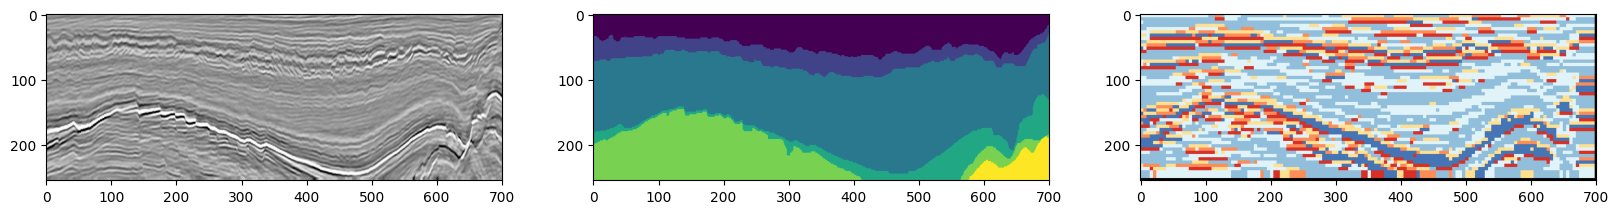

In [16]:
test(patch_size=(24,12), stride=5, dataset='f3', split='test1')

🔹 Gerando os splits de teste

✅ Gerou splits de teste
🔹 Começando os testes...

✅ Testes realizados para um slice

✅ K-Means realizado

🔹 Começando a segmentação das imagens...


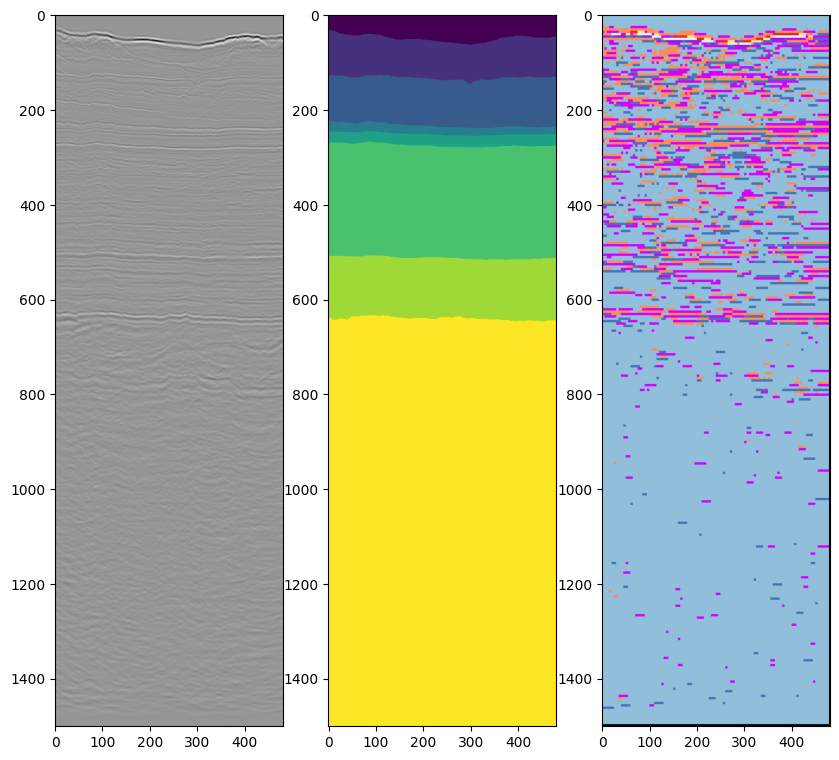

In [17]:
test(patch_size=(24,12), stride=5, dataset='penobscot')

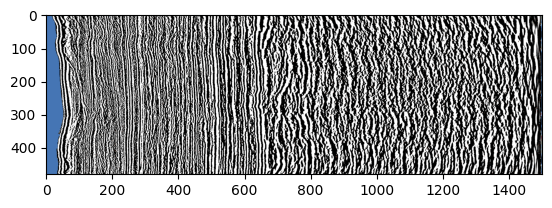

In [12]:
# Mostrando a label com o mesmo colormap do autoclustering

def decode_segmap(label_mask, plot=False):
        """Decode segmentation class labels into a color image
        Args:
            label_mask (numpy.ndarray): an (M,N) array of integer values denoting
              the class label at each spatial location.
            plot (bool, optional): whether to show the resulting color image
              in a figure.
        Returns:
            (numpy.ndarray, optional): the resulting decoded color image.
        """
        label_colours = np.asarray([ [69,117,180], [145,191,219], [224,243,248], [254,224,144], [252,141,89], [215,48,39]])
        r = label_mask.copy()
        g = label_mask.copy()
        b = label_mask.copy()
        for ll in range(0, 6):
            r[label_mask == ll] = label_colours[ll, 0]
            g[label_mask == ll] = label_colours[ll, 1]
            b[label_mask == ll] = label_colours[ll, 2]
        rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        if plot:
            plt.tight_layout()
            plt.imshow(rgb)
            plt.show()
        else:
            return rgb


labels = np.squeeze(h5py.File('datasets/penobscot/dataset.h5', 'r')['features'])

n = 100

labels = labels[n,:,:]
decode_segmap(labels.T, plot=True)